In [1]:
!pip install transformers

In [2]:
import os
import logging
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project

/content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project


In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_theme()

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project/Model')

from Utils import *

In [7]:
import random
import numpy as np
import torch

def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # for CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # for reproducibility

set_seed(123)

# Training

In [8]:
train_data_path = "Data/Dataset 3_final_df6B_train.xlsx"
val_data_path = "Data/Dataset 3_final_df6B_val.xlsx"
test_data_path = 'Data/Dataset 3_final_df6B_test.xlsx'
sheet_name = "Sheet1"

In [9]:
model_ckpt = "bert-base-uncased"
batch_size = 16

train_ds = SocialMediaDS(
    data_path=train_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_ds.collate_fn)

val_ds = SocialMediaDS(
    data_path=val_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

test_ds = SocialMediaDS(
    data_path=test_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
test_dl = DataLoader(test_ds, batch_size=batch_size, collate_fn=test_ds.collate_fn)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
print(f'Size of training data: {len(train_ds)}')
print(f'Size of validation data: {len(val_ds)}')
print(f'Size of validation data: {len(test_ds)}')

Size of training data: 3901
Size of validation data: 488
Size of validation data: 488


In [11]:
model = EmotionClassifier(model_ckpt, emotion_nlabels=7).to(device)
model.unfreeze_encoder()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [12]:
epochs = 5
loss_fn = focal_loss(2)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [13]:
mem = train_and_validate(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    model_save_path="Model/saved_models/model_masked_dataset3.pth",
    epochs=5
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 1.638	Acc: 0.402	F1: 0.429
Val Loss:   0.904	Acc:   0.540	F1:   0.515

New best F1: 0.515 - Model saved!
Epoch 2/5
Train Loss: 0.958	Acc: 0.571	F1: 0.583
Val Loss:   0.851	Acc:   0.597	F1:   0.567

New best F1: 0.567 - Model saved!
Epoch 3/5
Train Loss: 0.604	Acc: 0.712	F1: 0.724
Val Loss:   1.145	Acc:   0.599	F1:   0.576

New best F1: 0.576 - Model saved!
Epoch 4/5
Train Loss: 0.392	Acc: 0.802	F1: 0.808
Val Loss:   1.150	Acc:   0.607	F1:   0.595

New best F1: 0.595 - Model saved!
Epoch 5/5
Train Loss: 0.289	Acc: 0.851	F1: 0.857
Val Loss:   1.329	Acc:   0.611	F1:   0.593

Training completed!


# Evaluation

In [14]:
emo_preds, emo_targets, all_texts = evaluate_model(model, test_ds, test_dl)

  0%|          | 0/31 [00:00<?, ?it/s]

                precision    recall  f1-score   support
0                   36.21     36.84     36.52        57
1                   55.65     57.02     56.33       121
2                   52.38     52.38     52.38        21
3                   70.83     81.51     75.80       146
5                   63.06     51.47     56.68       136
6                   50.00     42.86     46.15         7

accuracy                                60.04       488
macro avg           54.69     53.68     53.98       488
weighted avg        59.76     60.04     59.62       488


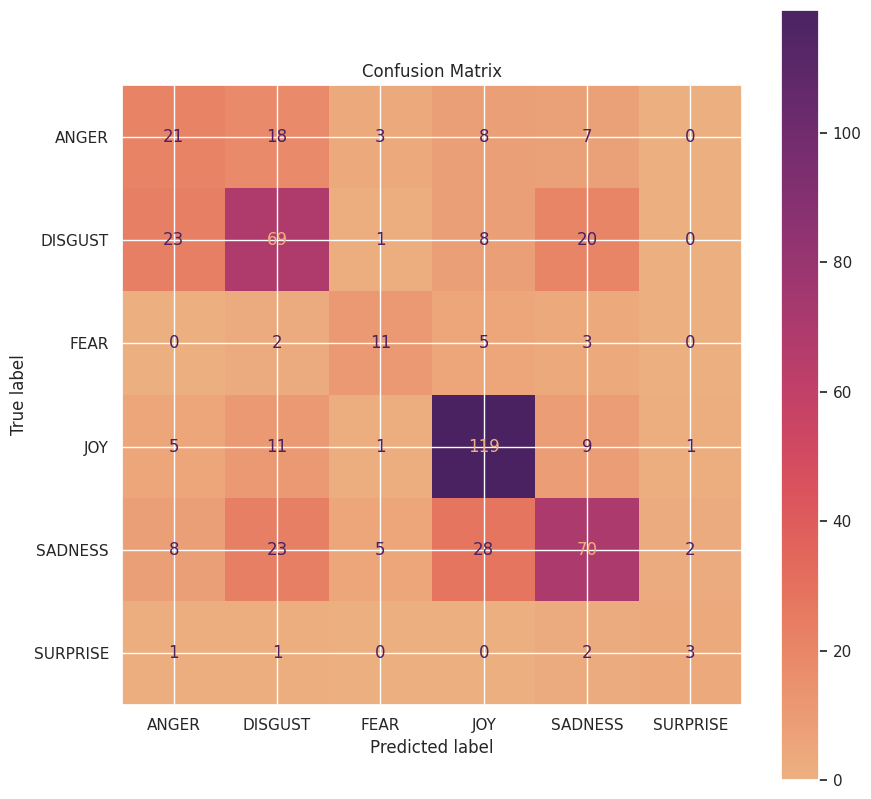

In [15]:
plot_confusion_matrix(emo_preds, emo_targets)